Aluna: Monica Maria Funk Drechsler - NUSP: 11275391


# EP 4 - Deep Learning

Usando como referência principal o notebook (muito bom) deste engenheiro de software da Google, adaptando para a MNIST (https://www.kaggle.com/code/ohseokkim/base-denoising-autoencoder-dimension-reduction/notebook) e depois o modelo de Variational Autoencoder fornecido pelo keras (https://keras.io/examples/generative/vae/), eu rodei primeiro usando o keras: https://colab.research.google.com/drive/1Y4lbwyzI8igbXFXbSB-nYtaJYYYLZ_a3?usp=sharing e testei algumas coisas por lá, depois adaptei para Pytorch neste notebook.  

## Instalações e bibliotecas

In [ ]:
!pip install umap-learn[plot]
!pip install "dask[dataframe]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 6.4 MB/s eta 0:00:00


In [ ]:
## Para fazer gráficos e visualizar o dataset e as previsões
import matplotlib.pyplot as plt #Para plots de gráficos e funções
import numpy as np #Para operações matemáticas mais básicas
import pandas as pd #Para trabalhar com bancos de dados
import seaborn as sns #Biblioteca necessária para os gráficos do umap
from umap import UMAP #Para fazer a redução de dimensão
import umap.plot #Para gerar gráficos do dataset
import plotly #Para fazer gráficos 3D
import plotly.express as px #Para fazer gráficos 3D

## Para construir as redes neurais
import torch
from torchvision import datasets #Para importar o dataset
from torchvision import transforms #Para transformar os dados em tensores
from torch import nn #Para determinar a arquitetura
from torch.utils.data import DataLoader #Para carregar o dataset pra treino
from torch.utils.data import Dataset #Para importar os dados já separados
from torch.utils.data import TensorDataset, random_split #Para fazer a separação dos dados (treinamento, validação, teste) e carregar dataset como tensor
import torch.nn.functional as F #Para fazer convoluções

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.35MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



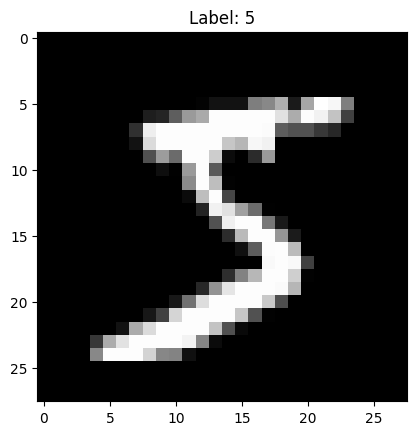

In [ ]:
#Fazendo o upload do MNIST usando o torchvision
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

#Para visualizar o primeiro elemento da amostra
image, label = mnist_train[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [ ]:
# Separando os dados em X e Y para o conjunto de treinamento e teste
x_train = [data[0] for data in mnist_train]
y_train = [data[1] for data in mnist_train]
x_test = [data[0] for data in mnist_test]
y_test = [data[1] for data in mnist_test]

# Convertendo as listas para tensores do PyTorch
x_train = torch.stack(x_train)
y_train = torch.tensor(y_train)
x_test = torch.stack(x_test)
y_test = torch.tensor(y_test)

In [ ]:
print('Dimensão das amostras de treino: ')
print(x_train.shape)
print(y_train.shape)
print('Dimensão das amostras de teste: ')
print(x_test.shape)
print(y_test.shape)

Dimensão das amostras de treino: 
torch.Size([60000, 1, 28, 28])
torch.Size([60000])
Dimensão das amostras de teste: 
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


## Visualizando a distribuição do Dataset

Como uma forma de visualizar o dataset, vamos utilizar o Umap, que aproxima os dados utilizando uma variedade e então projeta para o espaço 2D ou 3D. Esta parte conta apenas como um extra, encontrei ele no notebook que usei como fonte base e achei que seria uma perda deixar essa parte de fora.

### Em 2D

In [ ]:
labels = { 0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
          5: '5', 6: '6', 7: '7', 8 : '8', 9 : '9'}

x_train_flat = x_train.reshape(x_train.shape[0], -1)
y_train = pd.DataFrame(y_train,columns=['class'])
y_train.replace({'class': labels}, inplace=True)

<Axes: >

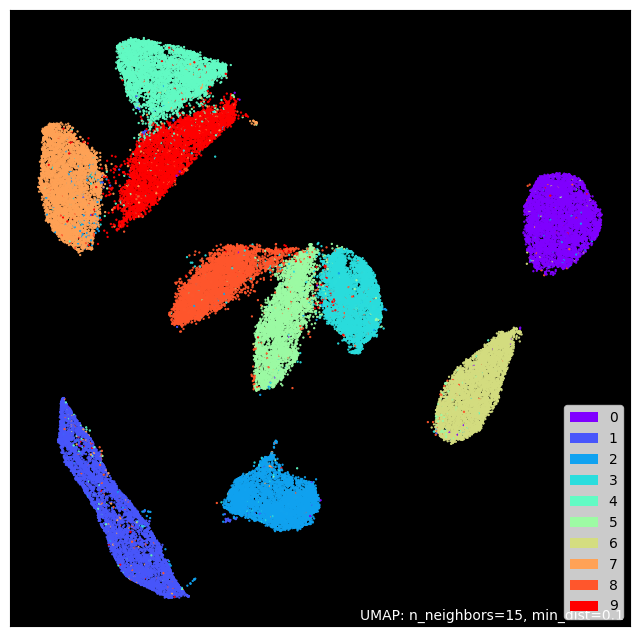

In [ ]:
mapper_org = umap.UMAP().fit(x_train_flat)
umap.plot.points(mapper_org, labels=y_train["class"], theme='fire')

### Em 3D

O gráfico é interativo, basta usar o seu mouse para visualizar sobre outras perspectivas

In [ ]:
umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(x_train_flat)
umap_df = pd.DataFrame(x_umap)
new_df = pd.concat([umap_df,y_train["class"]],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='class', labels={'color': 'class'}
)
fig.update_traces(marker_size=1)
fig.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Autoencoder

Começamos fazendo um autoencoder usando o modelo usando fully connected, conforme utilizado no notebook base (https://www.kaggle.com/code/ohseokkim/base-denoising-autoencoder-dimension-reduction/notebook). Logo após, testamos adicionando mais camadas e alterando o número da camada latente, para investigar a influência destes fatores.   

In [ ]:
latent_dim = 64

class Reshape(nn.Module):  # Definindo um Reshape para realocar a imagem
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
      nn.Flatten(),                  # (1,784)
      nn.Linear(784, latent_dim),    # (1,784)(784,64) => (1,64)
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 784),    # (1,64)(64,784) => (1,784)
      nn.Sigmoid(),
      Reshape((-1, 1, 28, 28))       #  (1,784) => (1,28,28)
      )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
# Definindo a Loss e o learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

# Treinando
epochs = 10
batch_size = 64
train_loader = DataLoader(list(zip(x_train,x_train)), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Plotando o progresso
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/15], Loss: 0.0158
Epoch [2/15], Loss: 0.0096
Epoch [3/15], Loss: 0.0080
Epoch [4/15], Loss: 0.0067
Epoch [5/15], Loss: 0.0063
Epoch [6/15], Loss: 0.0052
Epoch [7/15], Loss: 0.0047
Epoch [8/15], Loss: 0.0058
Epoch [9/15], Loss: 0.0054
Epoch [10/15], Loss: 0.0056
Epoch [11/15], Loss: 0.0053
Epoch [12/15], Loss: 0.0052
Epoch [13/15], Loss: 0.0054
Epoch [14/15], Loss: 0.0051
Epoch [15/15], Loss: 0.0061


Avaliando o treinamento:

In [ ]:
with torch.no_grad():
     encoded_data = autoencoder.encoder(x_test[0].unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu'))
     decoded_data = autoencoder.decoder(encoded_data)

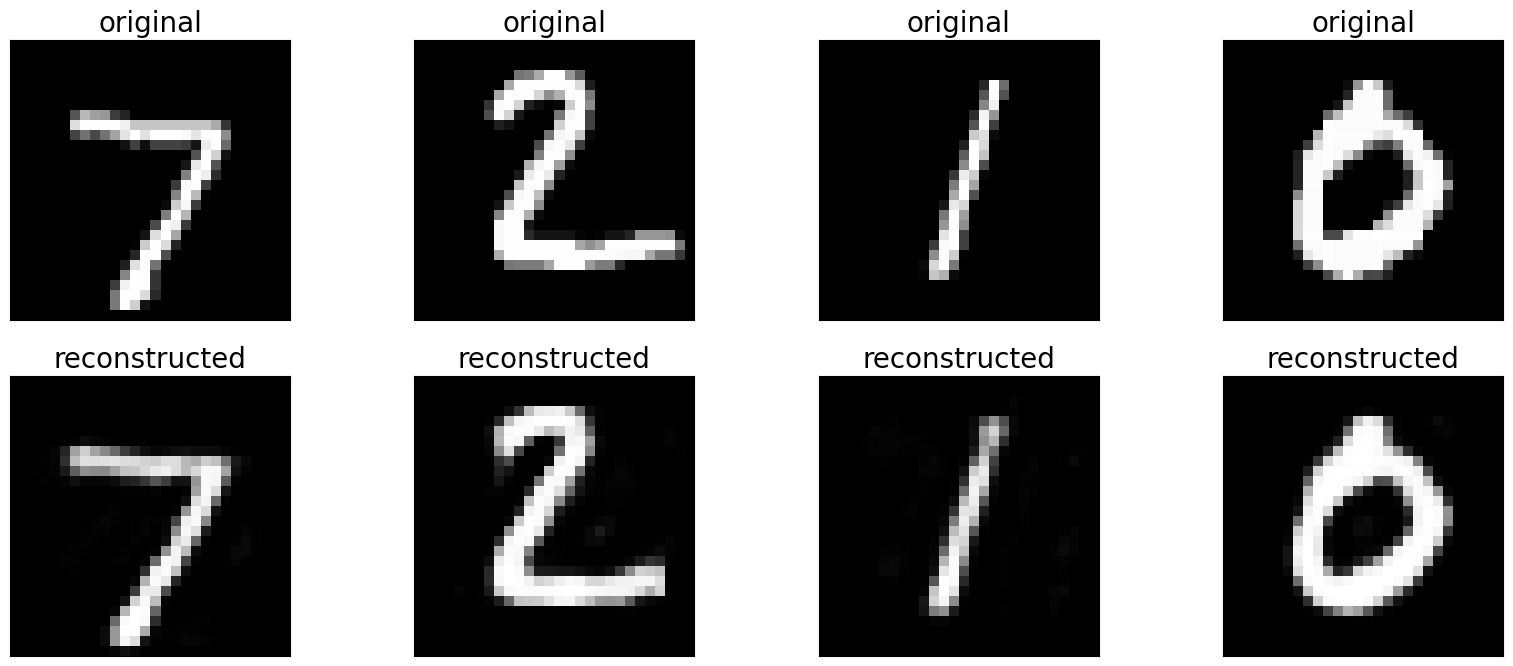

In [ ]:
n = 4
plt.figure(figsize=(20, 8))

with torch.no_grad():
    for i in range(n):
        encoded_data = autoencoder.encoder(x_test[i].unsqueeze(0).to(device))
        decoded_data = autoencoder.decoder(encoded_data)

        decoded_image = decoded_data.cpu().squeeze().numpy()
        # Amostra original
        ax = plt.subplot(2, n, i + 1)
        plt.title("original",fontsize=20)
        plt.imshow((x_test[i]).squeeze().numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Resultado do autoencoder
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed",fontsize=20)
        plt.imshow((decoded_image))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()

### Investigação: Adicionando mais camadas e alterando a arquitetura

Podemos neste caso atuarmos sob duas perspectivas: adicionar mais camadas e mudar o número da camada latente, ou manter a camada latente, adicionando camadas intermediárias.  

#### Adicionando mais camadas intermediárias

In [ ]:
latent_dim = 64

class Reshape(nn.Module):  # Definindo um Reshape para realocar a imagem
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
      nn.Flatten(),                  # (1,784)
      nn.Linear(784, 128),           # (1,784)(784, 128) => (1,128)
      nn.ReLU(),
      nn.Linear(128, latent_dim),    # (1,128)(128,64) => (1,64)
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 128),    # (1,64)(64,128) => (1,128)
      nn.ReLU(),
      nn.Linear(128,784),             # (1,128)(128,784) => (1,784)
      nn.Sigmoid(),
      Reshape((-1, 1, 28, 28))       #  (1,784) => (1,28,28)
      )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
# Definindo a Loss e o learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

# Treinando
epochs = 15
batch_size = 64
train_loader = DataLoader(list(zip(x_train,x_train)), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Plotando o progresso
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/15], Loss: 0.0211
Epoch [2/15], Loss: 0.0123
Epoch [3/15], Loss: 0.0123
Epoch [4/15], Loss: 0.0103
Epoch [5/15], Loss: 0.0090
Epoch [6/15], Loss: 0.0090
Epoch [7/15], Loss: 0.0083
Epoch [8/15], Loss: 0.0083
Epoch [9/15], Loss: 0.0078
Epoch [10/15], Loss: 0.0069
Epoch [11/15], Loss: 0.0065
Epoch [12/15], Loss: 0.0054
Epoch [13/15], Loss: 0.0053
Epoch [14/15], Loss: 0.0050
Epoch [15/15], Loss: 0.0058


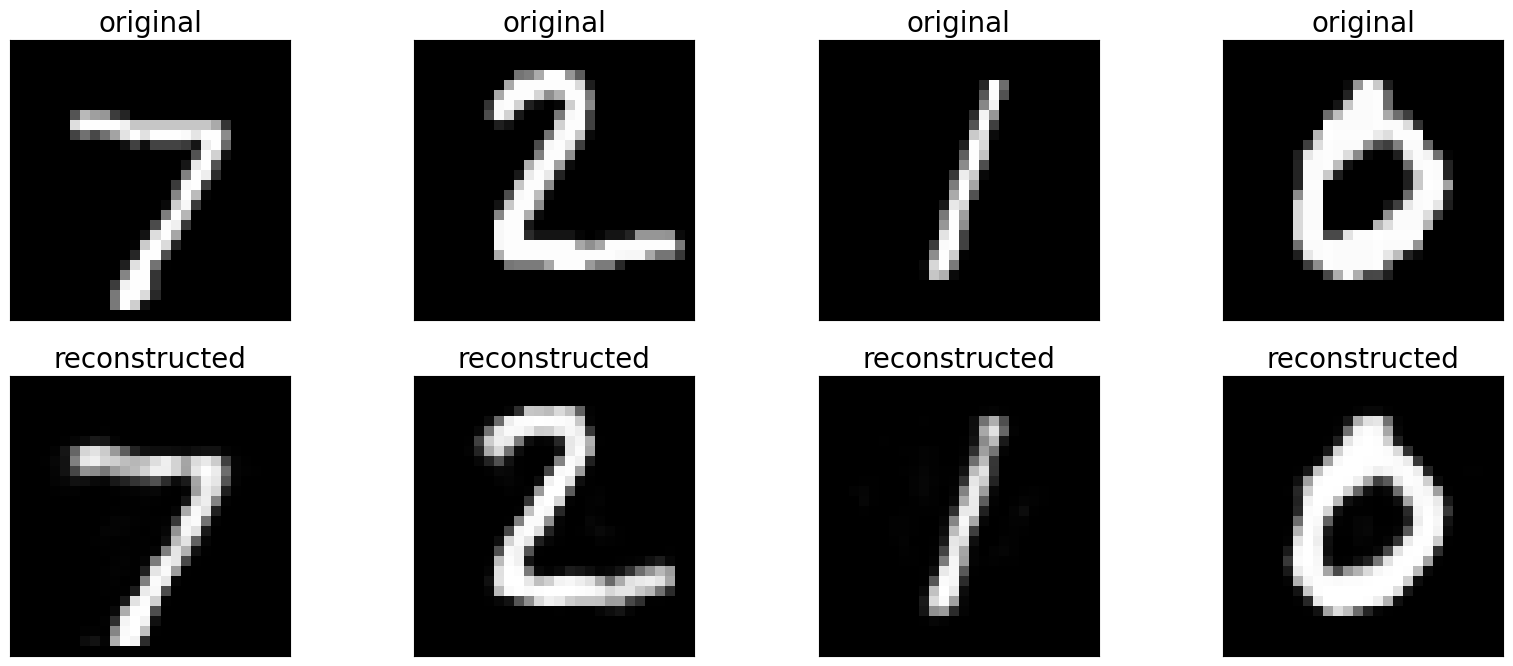

In [ ]:
n = 4
plt.figure(figsize=(20, 8))

with torch.no_grad():
    for i in range(n):
        encoded_data = autoencoder.encoder(x_test[i].unsqueeze(0).to(device))
        decoded_data = autoencoder.decoder(encoded_data)

        decoded_image = decoded_data.cpu().squeeze().numpy()
        # Amostra original
        ax = plt.subplot(2, n, i + 1)
        plt.title("original",fontsize=20)
        plt.imshow((x_test[i]).squeeze().numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Resultado do autoencoder
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed",fontsize=20)
        plt.imshow((decoded_image))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()

#### Alterando o tamanho do espaço latente


In [ ]:
latent_dim = 32

class Reshape(nn.Module):  # Definindo um Reshape para realocar a imagem
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
      nn.Flatten(),                  # (1,784)
      nn.Linear(784, latent_dim),    # (1,784)(784,32) => (1,32)
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 784),    # (1,32)(32,784) => (1,784)
      nn.Sigmoid(),
      Reshape((-1, 1, 28, 28))       #  (1,784) => (1,28,28)
      )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
# Definindo a Loss e o learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

# Treinando
epochs = 15
batch_size = 64
train_loader = DataLoader(list(zip(x_train,x_train)), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Plotando o progresso
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/15], Loss: 0.0244
Epoch [2/15], Loss: 0.0169
Epoch [3/15], Loss: 0.0140
Epoch [4/15], Loss: 0.0143
Epoch [5/15], Loss: 0.0129
Epoch [6/15], Loss: 0.0142
Epoch [7/15], Loss: 0.0120
Epoch [8/15], Loss: 0.0134
Epoch [9/15], Loss: 0.0124
Epoch [10/15], Loss: 0.0140
Epoch [11/15], Loss: 0.0131
Epoch [12/15], Loss: 0.0111
Epoch [13/15], Loss: 0.0133
Epoch [14/15], Loss: 0.0115
Epoch [15/15], Loss: 0.0138


In [ ]:
with torch.no_grad():
     encoded_data = autoencoder.encoder(x_test[0].unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu'))
     decoded_data = autoencoder.decoder(encoded_data)

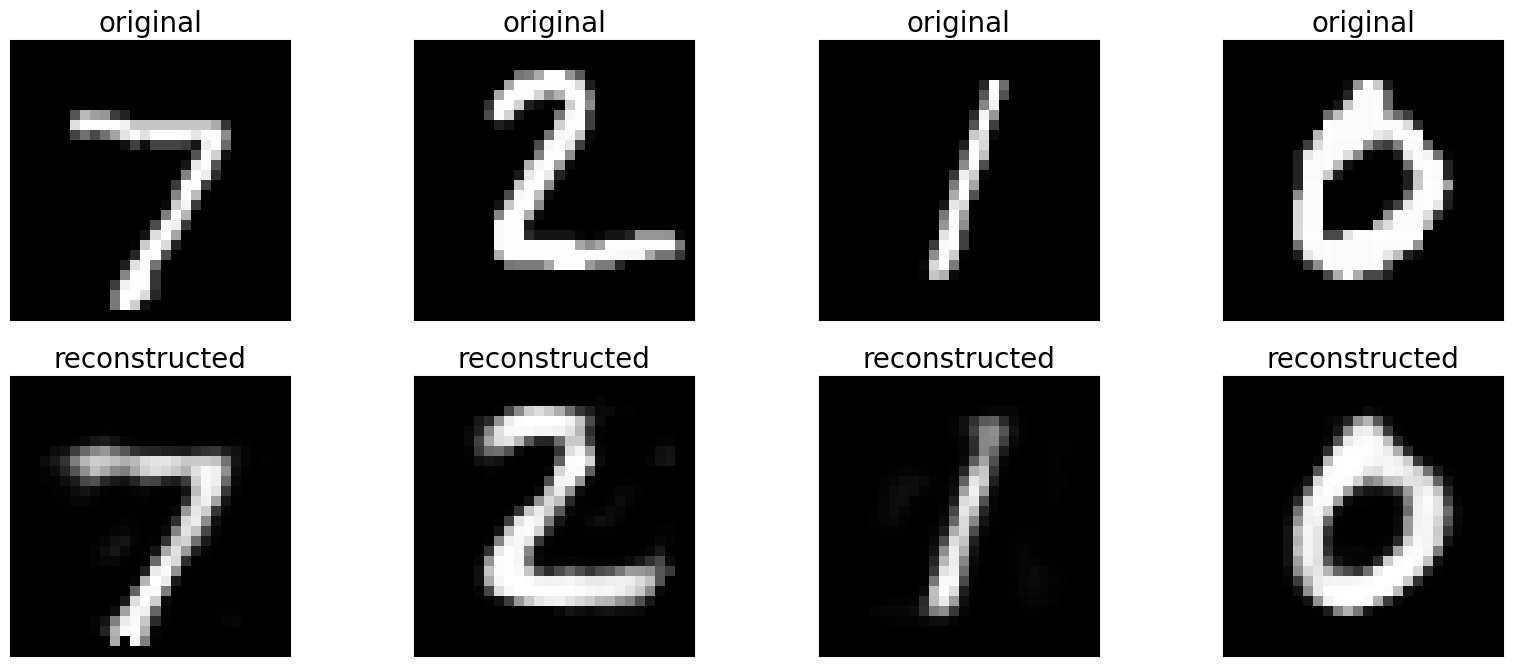

In [ ]:
n = 4
plt.figure(figsize=(20, 8))

with torch.no_grad():
    for i in range(n):
        encoded_data = autoencoder.encoder(x_test[i].unsqueeze(0).to(device))
        decoded_data = autoencoder.decoder(encoded_data)

        decoded_image = decoded_data.cpu().squeeze().numpy()
        # Amostra original
        ax = plt.subplot(2, n, i + 1)
        plt.title("original",fontsize=20)
        plt.imshow((x_test[i]).squeeze().numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Resultado do autoencoder
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed",fontsize=20)
        plt.imshow((decoded_image))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()

In [ ]:
latent_dim = 32

class Reshape(nn.Module):  # Definindo um Reshape para realocar a imagem
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
      nn.Flatten(),                  # (1,784)
      nn.Linear(784, 128),           # (1,784)(784, 128) => (1,128)
      nn.ReLU(),
      nn.Linear(128, latent_dim),    # (1,128)(128,64) => (1,64)
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 128),    # (1,64)(64,128) => (1,128)
      nn.ReLU(),
      nn.Linear(128,784),            # (1,128)(128,784) => (1,784)
      nn.Sigmoid(),
      Reshape((-1, 1, 28, 28))       #  (1,784) => (1,28,28)
      )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:

# Definindo a Loss e o learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

# Treinando
epochs = 15
batch_size = 64
train_loader = DataLoader(list(zip(x_train,x_train)), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Plotando o progresso
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/15], Loss: 0.0221
Epoch [2/15], Loss: 0.0175
Epoch [3/15], Loss: 0.0156
Epoch [4/15], Loss: 0.0145
Epoch [5/15], Loss: 0.0136
Epoch [6/15], Loss: 0.0113
Epoch [7/15], Loss: 0.0108
Epoch [8/15], Loss: 0.0107
Epoch [9/15], Loss: 0.0114
Epoch [10/15], Loss: 0.0103
Epoch [11/15], Loss: 0.0118
Epoch [12/15], Loss: 0.0098
Epoch [13/15], Loss: 0.0102
Epoch [14/15], Loss: 0.0118
Epoch [15/15], Loss: 0.0090


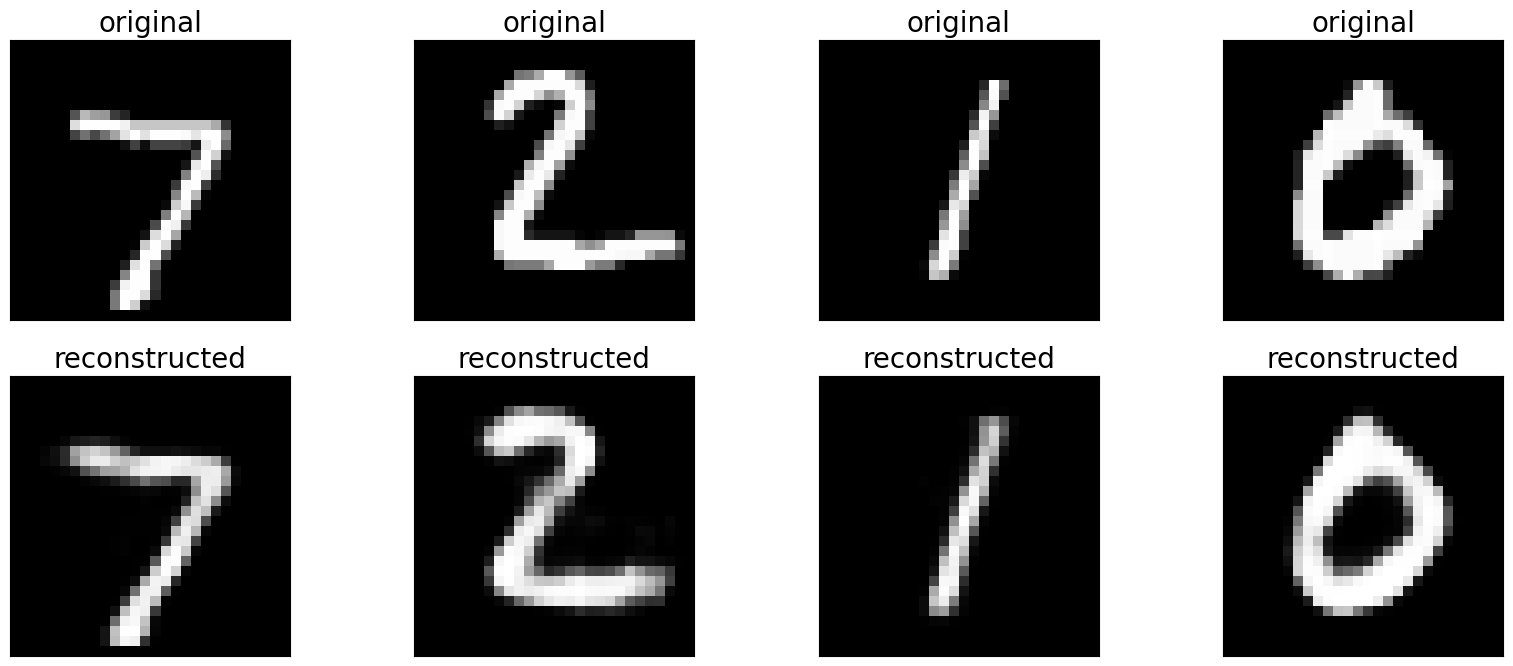

In [ ]:
n = 4
plt.figure(figsize=(20, 8))

with torch.no_grad():
    for i in range(n):
        encoded_data = autoencoder.encoder(x_test[i].unsqueeze(0).to(device))
        decoded_data = autoencoder.decoder(encoded_data)

        decoded_image = decoded_data.cpu().squeeze().numpy()
        # Amostra original
        ax = plt.subplot(2, n, i + 1)
        plt.title("original",fontsize=20)
        plt.imshow((x_test[i]).squeeze().numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Resultado do autoencoder
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed",fontsize=20)
        plt.imshow((decoded_image))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()

In [ ]:
latent_dim = 32

class Reshape(nn.Module):  # Definindo um Reshape para realocar a imagem
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
      nn.Flatten(),                  # (1,784)
      nn.Linear(784, 128),           # (1,784)(784, 128) => (1,128)
      nn.ReLU(),
      nn.Linear(128, latent_dim),    # (1,128)(128,64) => (1,64)
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 128),    # (1,64)(64,128) => (1,128)
      nn.ReLU(),
      nn.Linear(128,784),             # (1,128)(128,784) => (1,784)
      nn.Sigmoid(),
      Reshape((-1, 1, 28, 28))       #  (1,784) => (1,28,28)
      )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
# Definindo a Loss e o learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

# Treinando
epochs = 15
batch_size = 64
train_loader = DataLoader(list(zip(x_train,x_train)), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Plotando o progresso
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/15], Loss: 0.0168
Epoch [2/15], Loss: 0.0148
Epoch [3/15], Loss: 0.0151
Epoch [4/15], Loss: 0.0111
Epoch [5/15], Loss: 0.0104
Epoch [6/15], Loss: 0.0094
Epoch [7/15], Loss: 0.0075
Epoch [8/15], Loss: 0.0089
Epoch [9/15], Loss: 0.0093
Epoch [10/15], Loss: 0.0086
Epoch [11/15], Loss: 0.0109
Epoch [12/15], Loss: 0.0100
Epoch [13/15], Loss: 0.0081
Epoch [14/15], Loss: 0.0085
Epoch [15/15], Loss: 0.0095


In [ ]:
with torch.no_grad():
     encoded_data = autoencoder.encoder(x_test[0].unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu'))
     decoded_data = autoencoder.decoder(encoded_data)

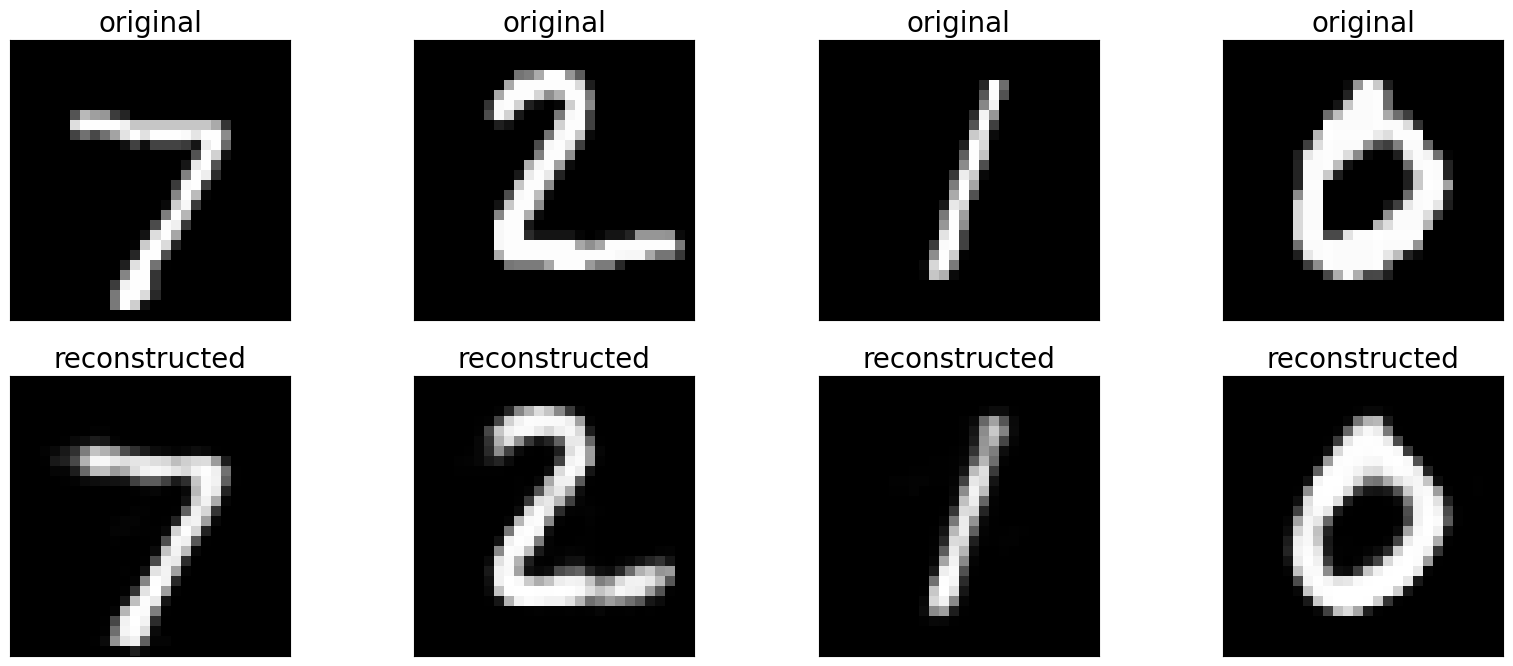

In [ ]:
n = 4
plt.figure(figsize=(20, 8))

with torch.no_grad():
    for i in range(n):
        encoded_data = autoencoder.encoder(x_test[i].unsqueeze(0).to(device))
        decoded_data = autoencoder.decoder(encoded_data)

        decoded_image = decoded_data.cpu().squeeze().numpy()
        # Amostra original
        ax = plt.subplot(2, n, i + 1)
        plt.title("original",fontsize=20)
        plt.imshow((x_test[i]).squeeze().numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Resultado do autoencoder
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed",fontsize=20)
        plt.imshow((decoded_image))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()

# Denoising Autoencoder

Começamos adicionando ruído nas amostras

In [ ]:
noise_factor = 0.2

# Adicionando ruído gaussiano
x_train_noisy = x_train + noise_factor * torch.randn(size =x_train.shape)
x_test_noisy = x_test + noise_factor * torch.randn(size=x_test.shape)

# Limitando os valores entre 0 e 1
x_train_noisy = torch.clamp(x_train_noisy, 0., 1.)
x_test_noisy = torch.clamp(x_test_noisy, 0., 1.)

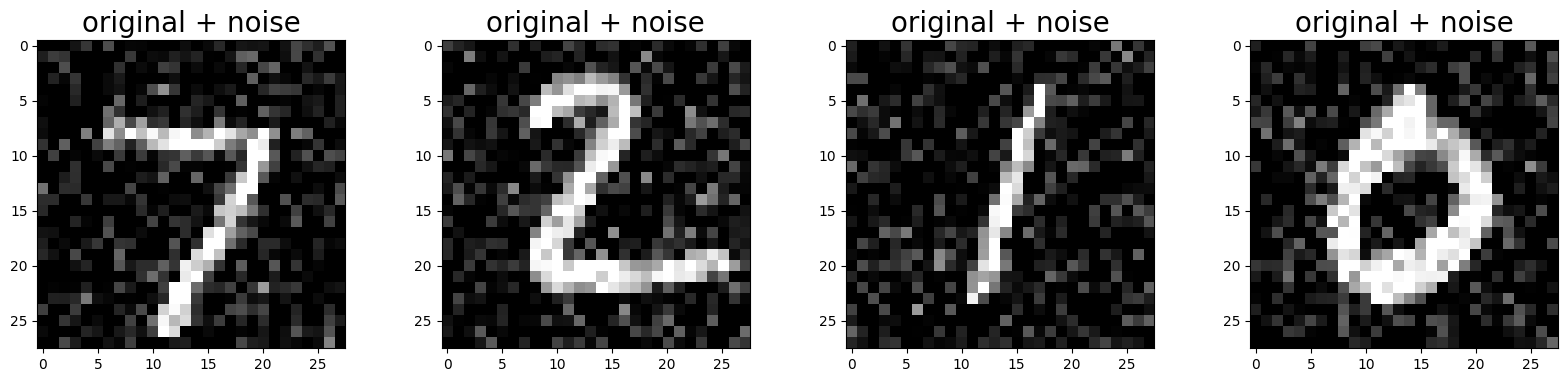

In [ ]:
n = 4
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise",fontsize=20)
    plt.imshow((x_test_noisy[i]).squeeze().numpy())
    plt.gray()
plt.show()

#### Distribuição dos dados com ruído

Podemos agora verificar se houve alguma variação da distribuição dos dados ao adicionarmos ruído.

In [ ]:
x_train_noisy_flat = x_train.reshape(x_train_noisy.shape[0], -1)
y_train = pd.DataFrame(y_train,columns=['class'])
y_train.replace({'class':labels}, inplace=True)

<Axes: >

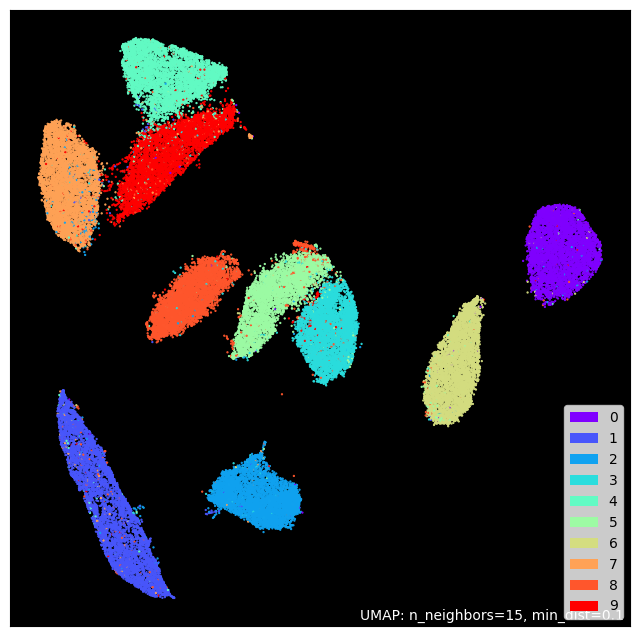

In [ ]:
mapper_noisy = umap.UMAP().fit(x_train_noisy_flat)
umap.plot.points(mapper_noisy, labels=y_train['class'], theme='fire')

Comparado com o dos dados sem ruído:

<Axes: >

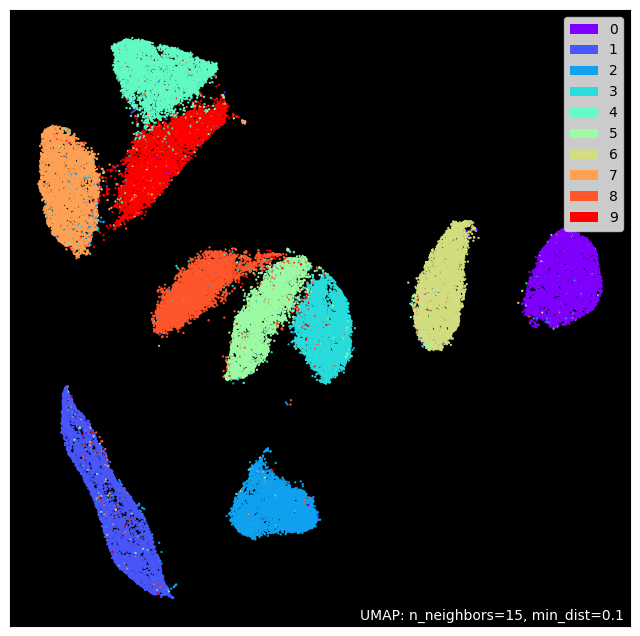

In [ ]:
mapper = umap.UMAP().fit(x_train_flat)
umap.plot.points(mapper, labels=y_train['class'], theme='fire')

O que dá para ver é que não há uma grande diferença de distribuição ao adicionarmos esta pequena quantia de ruído.

#### Utilizando a mesma rede fully conected do autoencoder

Começamos usando a mesma rede da parte fully conected, testando também com mais camadas e mudando a parte latente.

In [ ]:
latent_dim = 64

class Reshape(nn.Module):  # Definindo um Reshape para realocar a imagem
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
      nn.Flatten(),                  # (1,784)
      nn.Linear(784, latent_dim),    # (1,784)(784,64) => (1,64)
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 784),    # (1,64)(64,784) => (1,784)
      nn.Sigmoid(),
      Reshape((-1, 1, 28, 28))       #  (1,784) => (1,28,28)
      )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
# Definindo a Loss e o learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

# Treinando
epochs = 15
batch_size = 64
train_loader = DataLoader(list(zip(x_train_noisy,x_train_noisy)), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Plotando o progresso
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/15], Loss: 0.0299
Epoch [2/15], Loss: 0.0264
Epoch [3/15], Loss: 0.0244
Epoch [4/15], Loss: 0.0242
Epoch [5/15], Loss: 0.0244
Epoch [6/15], Loss: 0.0236
Epoch [7/15], Loss: 0.0227
Epoch [8/15], Loss: 0.0246
Epoch [9/15], Loss: 0.0225
Epoch [10/15], Loss: 0.0240
Epoch [11/15], Loss: 0.0237
Epoch [12/15], Loss: 0.0228
Epoch [13/15], Loss: 0.0255
Epoch [14/15], Loss: 0.0222
Epoch [15/15], Loss: 0.0219


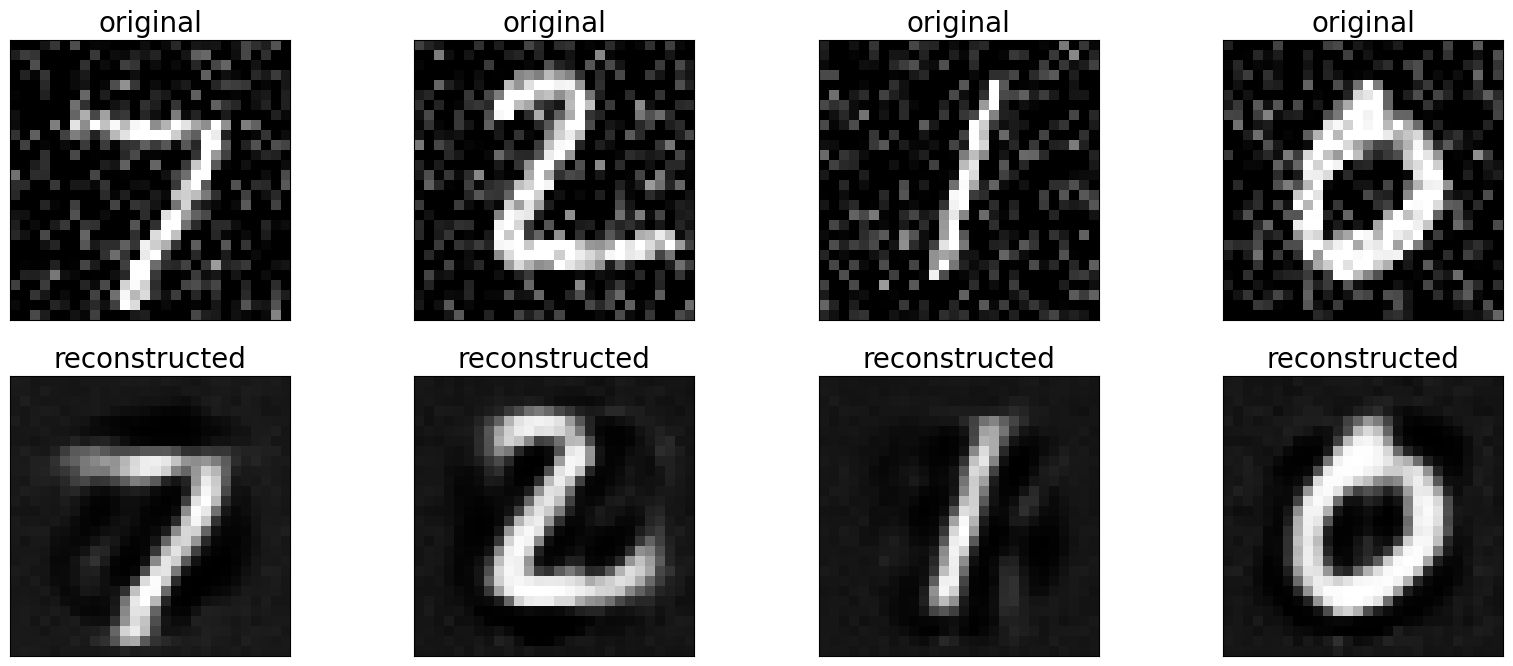

In [ ]:
n = 4
plt.figure(figsize=(20, 8))

with torch.no_grad():
    for i in range(n):
        encoded_data = autoencoder.encoder(x_test_noisy[i].unsqueeze(0).to(device))
        decoded_data = autoencoder.decoder(encoded_data)

        decoded_image = decoded_data.cpu().squeeze().numpy()
        # Amostra original
        ax = plt.subplot(2, n, i + 1)
        plt.title("original",fontsize=20)
        plt.imshow((x_test_noisy[i]).squeeze().numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Resultado do autoencoder
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed",fontsize=20)
        plt.imshow((decoded_image))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()

###### Adicionando mais camadas

In [ ]:
latent_dim = 64

class Reshape(nn.Module):  # Definindo um Reshape para realocar a imagem
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
      nn.Flatten(),                  # (1,784)
      nn.Linear(784, 128),           # (1,784)(784, 128) => (1,128)
      nn.ReLU(),
      nn.Linear(128, latent_dim),    # (1,128)(128,64) => (1,64)
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 128),    # (1,64)(64,128) => (1,128)
      nn.ReLU(),
      nn.Linear(128,784),             # (1,128)(128,784) => (1,784)
      nn.Sigmoid(),
      Reshape((-1, 1, 28, 28))       #  (1,784) => (1,28,28)
      )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
# Definindo a Loss e o learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

# Treinando
epochs = 15
batch_size = 64
train_loader = DataLoader(list(zip(x_train_noisy,x_train_noisy)), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Plotando o progresso
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/15], Loss: 0.0258
Epoch [2/15], Loss: 0.0243
Epoch [3/15], Loss: 0.0263
Epoch [4/15], Loss: 0.0253
Epoch [5/15], Loss: 0.0248
Epoch [6/15], Loss: 0.0243
Epoch [7/15], Loss: 0.0256
Epoch [8/15], Loss: 0.0243
Epoch [9/15], Loss: 0.0249
Epoch [10/15], Loss: 0.0236
Epoch [11/15], Loss: 0.0250
Epoch [12/15], Loss: 0.0230
Epoch [13/15], Loss: 0.0220
Epoch [14/15], Loss: 0.0239
Epoch [15/15], Loss: 0.0233


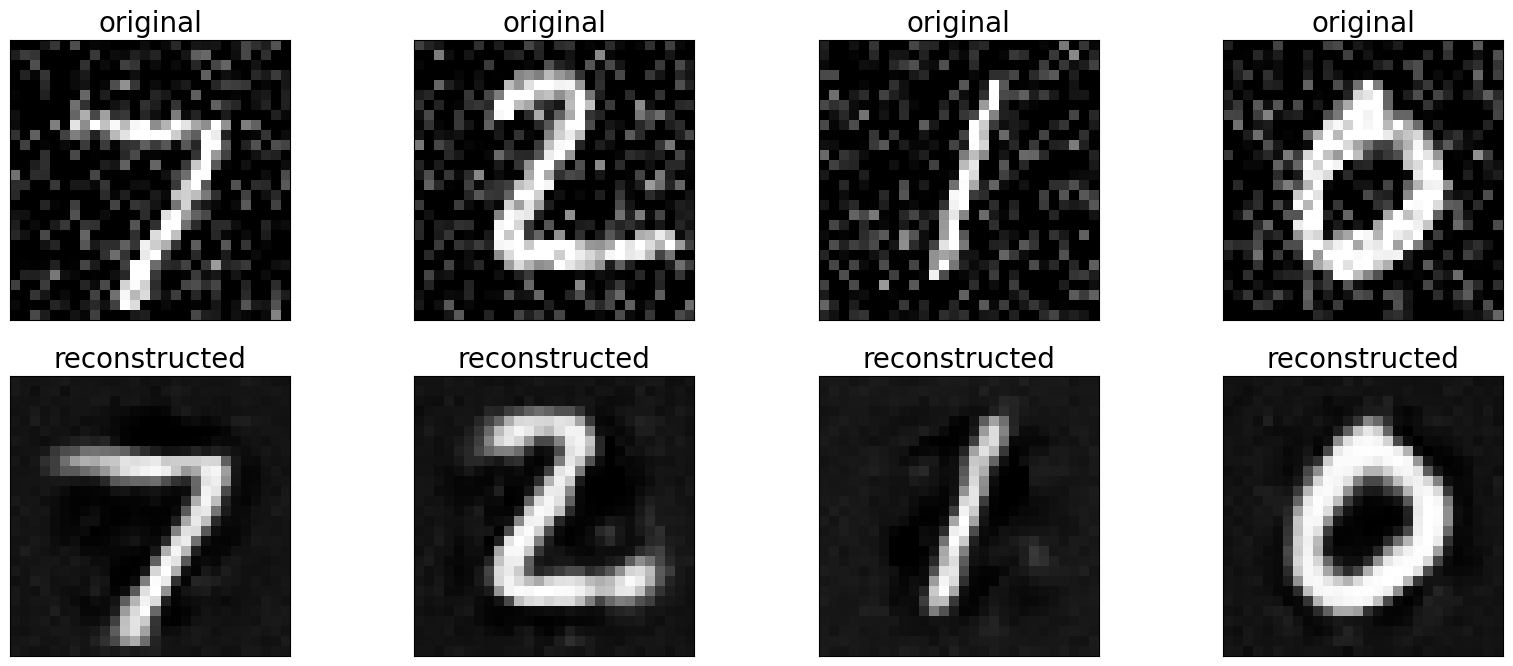

In [ ]:
n = 4
plt.figure(figsize=(20, 8))

with torch.no_grad():
    for i in range(n):
        encoded_data = autoencoder.encoder(x_test_noisy[i].unsqueeze(0).to(device))
        decoded_data = autoencoder.decoder(encoded_data)

        decoded_image = decoded_data.cpu().squeeze().numpy()
        # Amostra original
        ax = plt.subplot(2, n, i + 1)
        plt.title("original",fontsize=20)
        plt.imshow((x_test_noisy[i]).squeeze().numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Resultado do autoencoder
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed",fontsize=20)
        plt.imshow((decoded_image))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()

Veja que, ao adicionarmos mais camadas, obtivemos um resultado um pouco mais preciso e com um pouco menos de ruído.

###### Diminuíndo o tamanho do espaço latente


In [ ]:
latent_dim = 32

class Reshape(nn.Module):  # Definindo um Reshape para realocar a imagem
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
      nn.Flatten(),                  # (1,784)
      nn.Linear(784, latent_dim),    # (1,784)(784,32) => (1,32)
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 784),    # (1,32)(32,784) => (1,784)
      nn.Sigmoid(),
      Reshape((-1, 1, 28, 28))       #  (1,784) => (1,28,28)
      )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
# Definindo a Loss e o learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

# Treinando
epochs = 15
batch_size = 64
train_loader = DataLoader(list(zip(x_train_noisy,x_train_noisy)), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Plotando o progresso
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/15], Loss: 0.0392
Epoch [2/15], Loss: 0.0354
Epoch [3/15], Loss: 0.0328
Epoch [4/15], Loss: 0.0334
Epoch [5/15], Loss: 0.0323
Epoch [6/15], Loss: 0.0303
Epoch [7/15], Loss: 0.0328
Epoch [8/15], Loss: 0.0322
Epoch [9/15], Loss: 0.0310
Epoch [10/15], Loss: 0.0337
Epoch [11/15], Loss: 0.0307
Epoch [12/15], Loss: 0.0337
Epoch [13/15], Loss: 0.0334
Epoch [14/15], Loss: 0.0319
Epoch [15/15], Loss: 0.0318


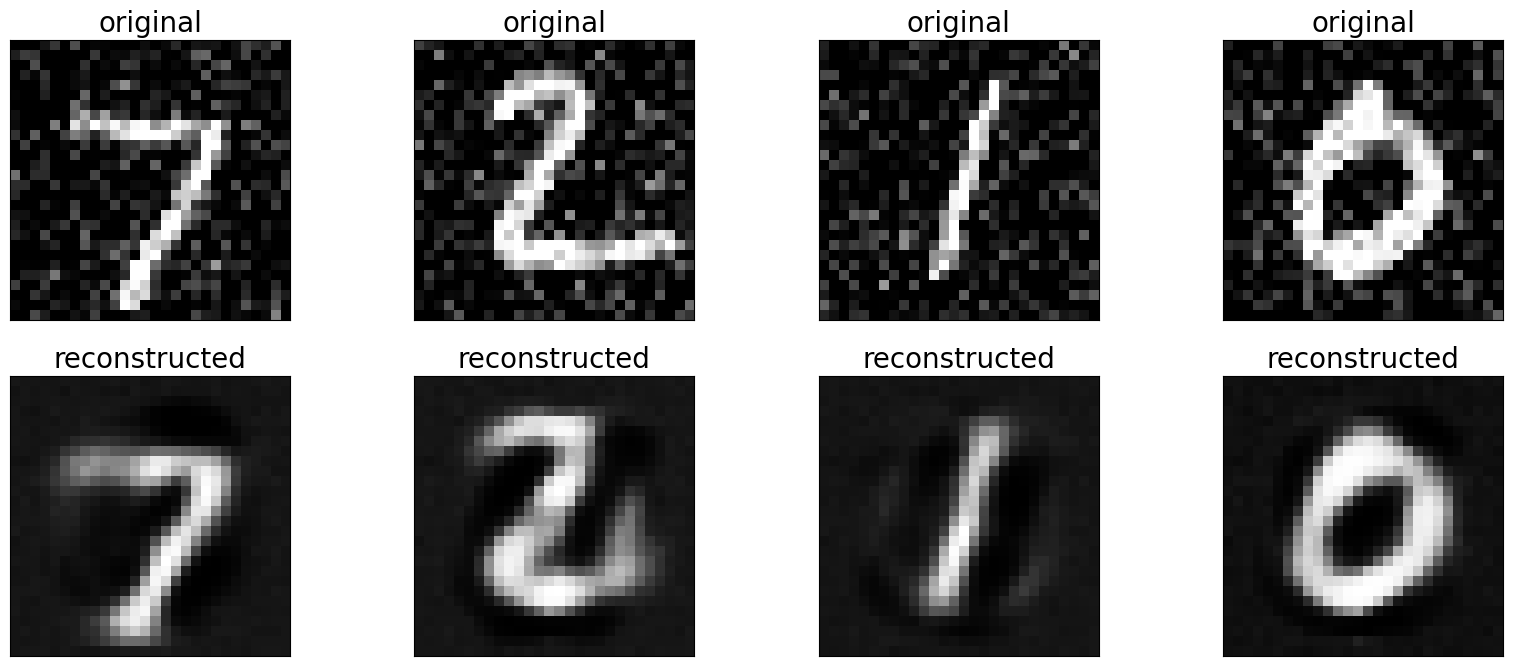

In [ ]:
n = 4
plt.figure(figsize=(20, 8))

with torch.no_grad():
    for i in range(n):
        encoded_data = autoencoder.encoder(x_test_noisy[i].unsqueeze(0).to(device))
        decoded_data = autoencoder.decoder(encoded_data)

        decoded_image = decoded_data.cpu().squeeze().numpy()
        # Amostra original
        ax = plt.subplot(2, n, i + 1)
        plt.title("original",fontsize=20)
        plt.imshow((x_test_noisy[i]).squeeze().numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Resultado do autoencoder
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed",fontsize=20)
        plt.imshow((decoded_image))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()

Adicionando mais camadas no espaço latente menor.

In [ ]:
latent_dim = 32

class Reshape(nn.Module):  # Definindo um Reshape para realocar a imagem
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
      nn.Flatten(),                  # (1,784)
      nn.Linear(784, 128),           # (1,784)(784, 128) => (1,128)
      nn.ReLU(),
      nn.Linear(128, latent_dim),    # (1,128)(128,64) => (1,64)
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 128),    # (1,64)(64,128) => (1,128)
      nn.ReLU(),
      nn.Linear(128,784),            # (1,128)(128,784) => (1,784)
      nn.Sigmoid(),
      Reshape((-1, 1, 28, 28))       #  (1,784) => (1,28,28)
      )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:

# Definindo a Loss e o learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

# Treinando
epochs = 15
batch_size = 64
train_loader = DataLoader(list(zip(x_train_noisy,x_train_noisy)), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Plotando o progresso
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/15], Loss: 0.0351
Epoch [2/15], Loss: 0.0320
Epoch [3/15], Loss: 0.0289
Epoch [4/15], Loss: 0.0310
Epoch [5/15], Loss: 0.0282
Epoch [6/15], Loss: 0.0298
Epoch [7/15], Loss: 0.0282
Epoch [8/15], Loss: 0.0298
Epoch [9/15], Loss: 0.0265
Epoch [10/15], Loss: 0.0262
Epoch [11/15], Loss: 0.0263
Epoch [12/15], Loss: 0.0275
Epoch [13/15], Loss: 0.0255
Epoch [14/15], Loss: 0.0255
Epoch [15/15], Loss: 0.0285


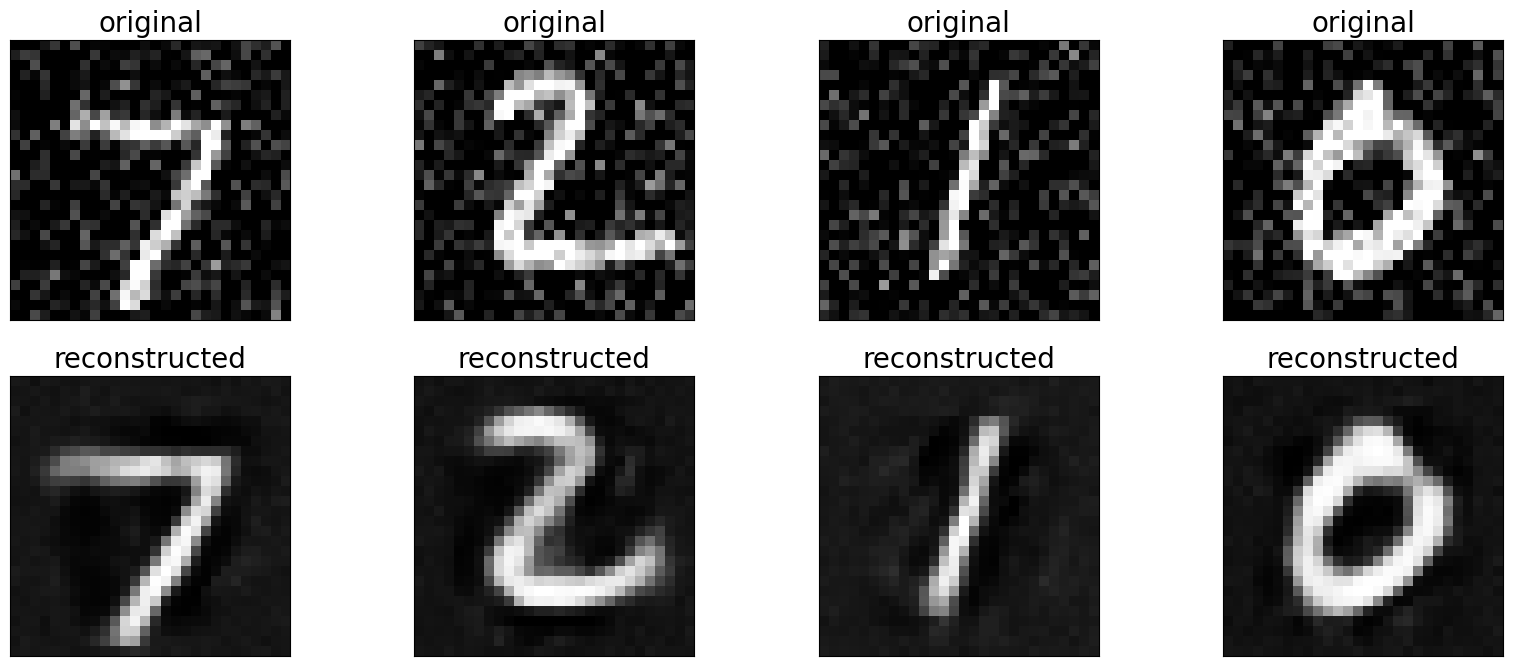

In [ ]:
n = 4
plt.figure(figsize=(20, 8))

with torch.no_grad():
    for i in range(n):
        encoded_data = autoencoder.encoder(x_test_noisy[i].unsqueeze(0).to(device))
        decoded_data = autoencoder.decoder(encoded_data)

        decoded_image = decoded_data.cpu().squeeze().numpy()
        # Amostra original
        ax = plt.subplot(2, n, i + 1)
        plt.title("original",fontsize=20)
        plt.imshow((x_test_noisy[i]).squeeze().numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Resultado do autoencoder
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed",fontsize=20)
        plt.imshow((decoded_image))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()

#### Utilizando Convoluções para o Encoder e Decoder

Para o Denoising, iremos utilizar também uma rede com parte convolucional para verificarmos seu resultado.

In [ ]:
class Denoise(nn.Module):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(1,16,kernel_size=3,stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(16,8,kernel_size=3,stride=2, padding=1),
      nn.ReLU())

    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1,output_padding =1),
      nn.Sigmoid())

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
# Definindo a Loss e o learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

# Treinando
epochs = 15
batch_size = 64
train_dataset = TensorDataset(torch.Tensor(x_train_noisy), torch.Tensor(x_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


for epoch in range(epochs):
    for batch_features, target in train_loader:
        batch_features = batch_features.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, target)

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Plotando o progresso
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")



Epoch [1/15], Loss: 0.0029
Epoch [2/15], Loss: 0.0031
Epoch [3/15], Loss: 0.0034
Epoch [4/15], Loss: 0.0031
Epoch [5/15], Loss: 0.0032
Epoch [6/15], Loss: 0.0031
Epoch [7/15], Loss: 0.0031
Epoch [8/15], Loss: 0.0029
Epoch [9/15], Loss: 0.0032
Epoch [10/15], Loss: 0.0031
Epoch [11/15], Loss: 0.0030
Epoch [12/15], Loss: 0.0033
Epoch [13/15], Loss: 0.0031
Epoch [14/15], Loss: 0.0033
Epoch [15/15], Loss: 0.0027


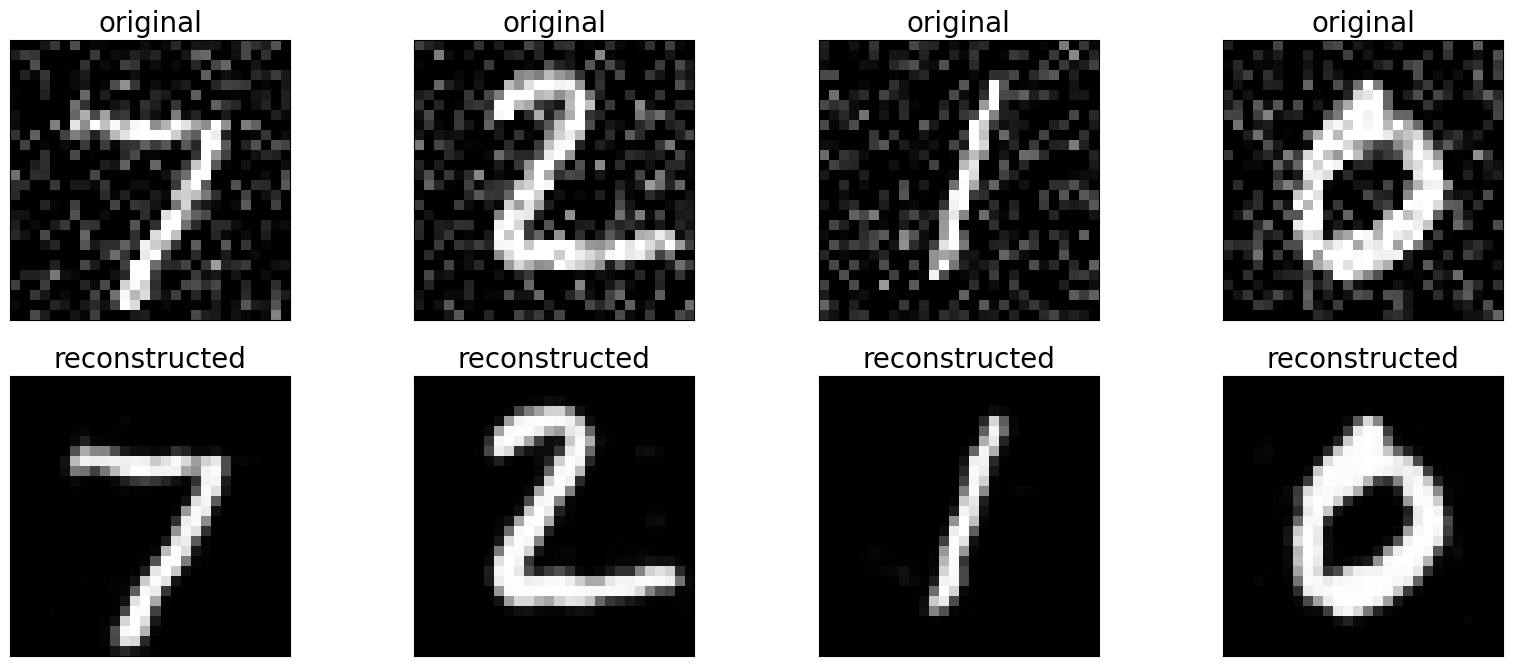

In [ ]:
n = 4
plt.figure(figsize=(20, 8))

with torch.no_grad():
    for i in range(n):
        encoded_data = autoencoder.encoder(x_test_noisy[i].unsqueeze(0).to(device))
        decoded_data = autoencoder.decoder(encoded_data)

        decoded_image = decoded_data.cpu().squeeze().numpy()
        # Amostra original
        ax = plt.subplot(2, n, i + 1)
        plt.title("original",fontsize=20)
        plt.imshow((x_test_noisy[i]).squeeze().numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Resultado do autoencoder
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed",fontsize=20)
        plt.imshow((decoded_image))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()

Note que mesmo uma rede simples com parte convolucional apresentou um melhor resultado para fazer o denoising, obtendo números mais precisos e limpos.

# Variational Autoencoder

Para o variational autoencoder, primeiro utilizamos o exemplo do monitor (de letra a letra, pois tem uma leve alteração na forma de incluir as amotras) e depois empregamos uma forma semelhante ao tutorial do Keras (https://keras.io/examples/generative/vae/), para visualizarmos também a variação conforme a inclusão de ruído.

## Seguindo o do monitor

Dataset carregado em Tensores com as seguintes dimensões:

all_training_data: X = torch.Size([60000, 28, 28]), intervalo: [0, 255]
                     training:    54000 samples
                     validation:   6000 samples

test_data: X_test = torch.Size([10000, 28, 28]) [0, 255]


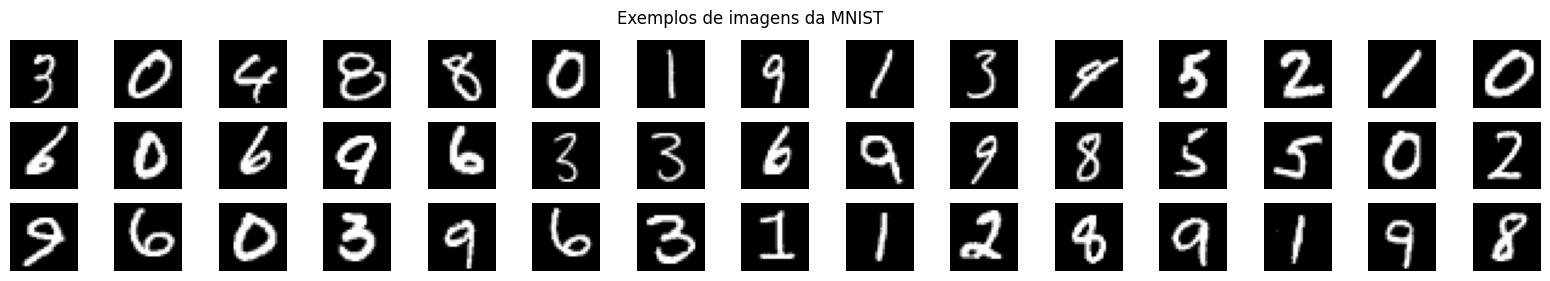

In [ ]:
def carrega_dataset(validation_set_percent=0.1, batch_size=128, verbose=False):
  transform_list = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.5), (0.5)),
    ]
  )

  training_data = datasets.MNIST(root="data", train=True, download=True, transform=transform_list)
  test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform_list)

  # Particiona o conjunto de treinamento e validação
  n_val = int(len(training_data) * validation_set_percent)
  n_train = len(training_data) - n_val
  train_set, val_set = random_split(
    training_data, [n_train, n_val], generator=torch.Generator().manual_seed(0)
  )

  if verbose:
    print("Dataset carregado em Tensores com as seguintes dimensões:\n")
    print(f"all_training_data: X = {training_data.data.size()}, intervalo: [{training_data.data.min().item()}, {training_data.data.max().item()}]")
    print(f"                     training:   {len(train_set.indices):6} samples")
    print(f"                     validation: {len(val_set.indices):6} samples")
    print()
    print(f"test_data: X_test = {test_data.data.shape} [{test_data.data.min().item()}, {test_data.data.max().item()}]")

    figure = plt.figure(figsize=(20, 3))
    plt.suptitle("Exemplos de imagens da MNIST")
    rows, cols = 3, 15
    for i in range(1, rows * cols + 1):
      sample_idx = torch.randint(len(training_data), size=(1,)).item()
      img, label = training_data[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

  train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
  val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=True)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True)

  return (train_dataloader, val_dataloader, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = carrega_dataset(validation_set_percent = 0.1, verbose=True)

In [ ]:
def vae_loss(recons, input, mu, log_var, kld_weight):
    """
    Função para calcular a perda de um Variational Autoencoder (VAE).

    Parâmetros:
    - recons: Reconstrução produzida pelo decodificador do VAE.
    - input: Entrada original fornecida ao VAE.
    - mu: Vetor de médias da distribuição latente (gerado pelo codificador).
    - log_var: Vetor do logaritmo da variância da distribuição latente (gerado pelo codificador).
    - kld_weight: Fator de peso para ajustar a importância da perda KLD em relação à perda de reconstrução.

    Retorno:
    - Soma da perda de reconstrução e da perda KLD ponderada.
    """

    # Calcula a perda de reconstrução usando o erro médio quadrático (MSE)
    recons_loss = F.mse_loss(recons, input)

    # Calcula a perda de divergência Kullback-Leibler (KLD) entre a distribuição latente e uma normal padrão
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)

    # Retorna a soma da perda de reconstrução e da perda KLD ponderada
    return recons_loss + kld_weight * kld_loss

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size):
        super(VariationalAutoencoder, self).__init__()

        # Projeção inicial dos dados para 512 dimensões
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size,512)
        )

        # Camadas para estimar os parâmetros da distribuição latente (μ e log(σ²))
        self.fc21 = nn.Linear(512, 10)  # Gera a média (μ)
        self.fc22 = nn.Linear(512, 10)  # Gera o logaritmo da variância (log(σ²))

        # Atributo para armazenar as embeddings latentes
        self.embeddings = None

        self.relu = nn.ReLU()

        # Camadas de decodificação para reconstruir os dados no espaço original
        self.fc3 = nn.Linear(10, 512)
        self.fc4 = nn.Linear(512, input_size)


    # Método de codificação: reduz os dados para o espaço latente
    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    # Método de decodificação: reconstrói os dados a partir do espaço latente
    def decode(self, z):
        z = self.relu(self.fc3(z))
        return torch.tanh(self.fc4(z))

    # Truque de reparametrização: amostra do espaço latente de forma diferenciável
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    # Forward: executa todo o fluxo do VAE
    def forward(self,x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        prediction = self.decode(z)
        self.embeddings = z
        return prediction, mu, logvar

    # Método para gerar amostras a partir do espaço latente
    def sample(self, num_samples:int):
        z = torch.randn(num_samples, 10)  # Gera vetores aleatórios no espaço latente
        z = z.cuda()

        samples = self.decode(z) # Decodifica os vetores para gerar dados
        return samples

vae = VariationalAutoencoder(28*28).to('cuda')

In [ ]:
# Hiperparâmetros
epochs = 30
batch_size= 256
learning_rate = 3.5e-3
loss_fn = vae_loss
optimizer = torch.optim.AdamW(vae.parameters(), lr=learning_rate)

In [ ]:
@torch.inference_mode()
def eval_loop(dataloader, model, loss_fn):
  model.eval()
  num_batches = len(dataloader)
  eval_loss = 0

  ground_truth = None
  prediction = None

  for X, y in dataloader:
    X = X.cuda()
    ground_truth = X
    prediction, mu, logvar = model(X)
    kld_weight = X.shape[0]/60000
    X = X.view(-1, 784)
    eval_loss += loss_fn(prediction, X, mu, logvar, kld_weight).item()

  eval_loss /= num_batches

  del X, prediction
  return eval_loss

def train_loop(dataloader, model, loss_fn,  optimizer):
  model.train()
  train_loss = 0
  num_batches = len(dataloader)

  for _, (X, _) in enumerate(dataloader):
    X = X.cuda()
    prediction, mu, logvar = model(X)
    X = X.view(-1, 784)
    kld_weight = X.shape[0]/60000
    loss = loss_fn(prediction, X, mu, logvar, kld_weight)

    with torch.no_grad():
      train_loss += loss.item()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  train_loss /= num_batches

  del X, prediction, loss
  return train_loss

In [ ]:
train_dataloader = DataLoader(list(zip(x_train,x_train)), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(x_test,x_test)), batch_size=batch_size, shuffle=True)

for t in range(epochs):
  print(f"Epoch {t+1:2}/{epochs}", end='')
  train_loss = train_loop(train_dataloader, vae, loss_fn, optimizer)
  val_loss = eval_loop(val_dataloader, vae, loss_fn)
  print(f"\t train_loss={train_loss:.3f}  val_loss={val_loss:.3f}")


print("Treinamento concluído!")

Epoch  1/30	 train_loss=0.058  val_loss=3.845
Epoch  2/30	 train_loss=0.058  val_loss=4.086
Epoch  3/30	 train_loss=0.058  val_loss=4.334
Epoch  4/30	 train_loss=0.058  val_loss=4.217
Epoch  5/30	 train_loss=0.058  val_loss=3.944
Epoch  6/30	 train_loss=0.058  val_loss=3.999
Epoch  7/30	 train_loss=0.058  val_loss=3.893
Epoch  8/30	 train_loss=0.058  val_loss=4.223
Epoch  9/30	 train_loss=0.058  val_loss=4.569
Epoch 10/30	 train_loss=0.058  val_loss=4.868
Epoch 11/30	 train_loss=0.058  val_loss=4.566
Epoch 12/30	 train_loss=0.058  val_loss=4.490
Epoch 13/30	 train_loss=0.058  val_loss=4.093
Epoch 14/30	 train_loss=0.058  val_loss=4.087
Epoch 15/30	 train_loss=0.058  val_loss=4.166
Epoch 16/30	 train_loss=0.058  val_loss=4.365
Epoch 17/30	 train_loss=0.058  val_loss=3.916
Epoch 18/30	 train_loss=0.058  val_loss=4.060
Epoch 19/30	 train_loss=0.058  val_loss=4.236
Epoch 20/30	 train_loss=0.058  val_loss=4.037
Epoch 21/30	 train_loss=0.058  val_loss=3.673
Epoch 22/30	 train_loss=0.058  val

(-0.5, 27.5, 27.5, -0.5)

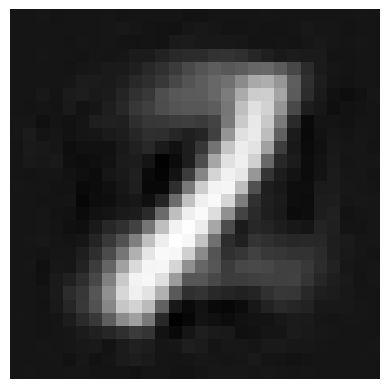

In [ ]:
exemplos_gerado = vae.sample(1).view(-1, 28, 28).detach().cpu().numpy()
plt.imshow(exemplos_gerado[0],  cmap="gray")
plt.axis('off')

## Seguindo o tutorial do Keras adaptando para Pytorch

In [ ]:
class Sampling(nn.Module):

    def __init__(self):
      super().__init__()

    def forward(self, inputs):
      z_mean, z_log_var = inputs
      batch = z_mean.size(0)
      dim = z_mean.size(1)
      epsilon = torch.randn(batch, dim)
      return z_mean + torch.exp(0.5 * z_log_var) *epsilon

In [ ]:
class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    self.latent_dim = latent_dim
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(7*7*64, 16)
    self.fc_mean = nn.Linear(16, latent_dim)
    self.fc_logvar = nn.Linear(16, latent_dim)
    self.sampling = Sampling()

  def forward(self, x):
    x = torch.relu(self.conv1(x))
    x = torch.relu(self.conv2(x))
    x = self.flatten(x)
    x = torch.relu(self.fc1(x))
    z_mean = self.fc_mean(x)
    z_log_var = self.fc_logvar(x)
    z = self.sampling([z_mean, z_log_var])
    return z_mean, z_log_var, z


encoder = Encoder(latent_dim=2)

In [ ]:
class ReshapeLayer(nn.Module):
  def __init__(self, *args):
    super(ReshapeLayer, self).__init__()
    self.shape = args

  def forward(self, x):
    return x.view(-1, *self.shape)

class Decoder(nn.Module):
  def __init__(self, latent_dim=2):
    super(Decoder, self).__init__()
    self.latent_dim = latent_dim
    self.fc1 = nn.Linear(latent_dim, 7*7*64)
    self.reshape = ReshapeLayer(64,7,7)
    self.deconv1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding =1)

  def forward(self, z):
    x = torch.relu(self.fc1(z))
    x = self.reshape(x)
    x = torch.relu(self.deconv1(x))
    x = torch.relu(self.deconv2(x))
    x = torch.sigmoid(self.deconv3(x))
    return x

decoder = Decoder(latent_dim=2)

In [ ]:
class VAE(nn.Module):
  def __init__(self, encoder, decoder):
    super(VAE, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, x):
    z_mean, z_log_var, z = self.encoder(x)
    reconstruction = self.decoder(z)
    return reconstruction, z_mean, z_log_var

  def loss_function(self, recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x.view(-1,784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

vae = VAE(encoder, decoder)

In [ ]:
# Definindo a Loss e o learning rate
vae = VAE(encoder, decoder)
optimizer = torch.optim.Adam(vae.parameters())

# Treinando
epochs = 30
batch_size = 128
train_loader = DataLoader(list(zip(x_train,x_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(x_test,x_test)), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
  for batch_idx, (data, _) in enumerate(train_loader):
    #forward pass
    recon_batch, mu, logvar = vae(data)
    loss = vae.loss_function(recon_batch, data, mu, logvar)

    #Backward prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Verificar o progresso
    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch +1,
             batch_idx *len(data), len(train_loader.dataset), 100 *batch_idx /
             len(train_loader), loss.item()/ len(data)))


Train Epoch: 1 [0/60000 (0%)]	Loss: 531.605591
Train Epoch: 1 [12800/60000 (21%)]	Loss: 205.200439
Train Epoch: 1 [25600/60000 (43%)]	Loss: 190.054276
Train Epoch: 1 [38400/60000 (64%)]	Loss: 180.191391
Train Epoch: 1 [51200/60000 (85%)]	Loss: 169.449692
Train Epoch: 2 [0/60000 (0%)]	Loss: 168.392853
Train Epoch: 2 [12800/60000 (21%)]	Loss: 167.073242
Train Epoch: 2 [25600/60000 (43%)]	Loss: 162.585236
Train Epoch: 2 [38400/60000 (64%)]	Loss: 172.423813
Train Epoch: 2 [51200/60000 (85%)]	Loss: 165.838409
Train Epoch: 3 [0/60000 (0%)]	Loss: 165.470413
Train Epoch: 3 [12800/60000 (21%)]	Loss: 161.844940
Train Epoch: 3 [25600/60000 (43%)]	Loss: 160.080902
Train Epoch: 3 [38400/60000 (64%)]	Loss: 159.280594
Train Epoch: 3 [51200/60000 (85%)]	Loss: 167.864532
Train Epoch: 4 [0/60000 (0%)]	Loss: 153.578079
Train Epoch: 4 [12800/60000 (21%)]	Loss: 165.643188
Train Epoch: 4 [25600/60000 (43%)]	Loss: 160.739166
Train Epoch: 4 [38400/60000 (64%)]	Loss: 163.565079
Train Epoch: 4 [51200/60000 (85%

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    if torch.cuda.is_available():
        vae.cuda()

    vae.eval()

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]]).float()
            if torch.cuda.is_available():
                z_sample = z_sample.cuda()
            with torch.no_grad():
                x_decoded = vae.decoder(z_sample)
            digit = x_decoded[0].cpu().numpy().reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

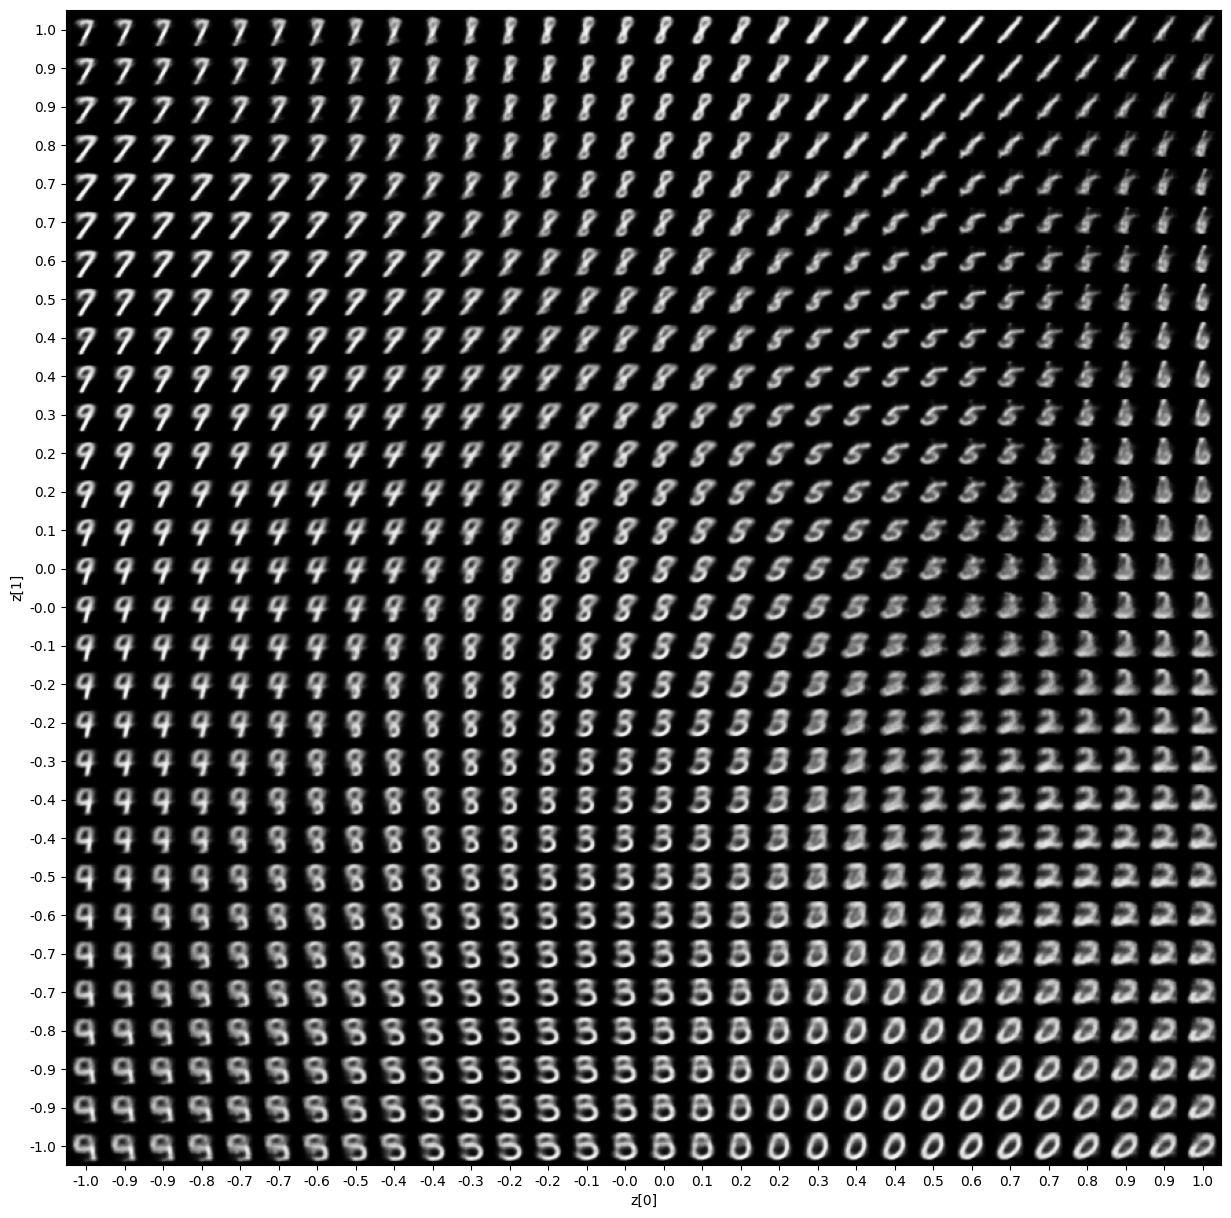

In [ ]:

plot_latent_space(vae, n=30, figsize=15)

# Conclusões e comentários

Mesmo uma rede simples pode realizar um autoencoder da MNIST sem problemas. Ao adicionarmos mais camadas, obtemos um resultado melhor, e a dimensão da camada latente é um fator importante que determina diretamente a qualidade da imagem resultante.
Já para o Denoising, por mais que uma rede simples já obtenha um resultado com um pouco de ruído, mesmo uma rede simples de CNN obtêm um ótimo resultado, com os números bem definidos.
Para o Variational, o gráfico obtido como resultado, mostrando a influência do valor da gaussiana no número formado é uma forma ótima de entender diretamente a influência dos fatores, de uma maneira visual.

O que ainda poderia ser explorado:
 - Alguns treinamentos não tiveram bons resultados (ou não os melhores), poderia ter colocado critério de parada (como, parar se a loss crescer em comparação a época, ou utilizar alguma técnica de regularização ou mais cuidado ao treinar).
 - Adicionar mais ruído no modelo Denoising e ver como isso prejudica/ajuda o resultado, bem como a sua influência na distribuição.
 - Verificar a distribuição resultante após o Variational Autoencoder e comparar com a distribuição inicial.
 - Utilizar outros datasets.

Pontos negativos:
  - Assim como previsto, a rede vai ficando mais complexa, então acaba ficando mais complicado em escrever a rede e treiná-la. Ainda, cada tutorial faz de uma certa forma, o que faz ter que se adaptar.  

Pontos positivos:
 - Este trabalho foi muito divertido de ser feito. Por usar a MNIST, as coisas rodavam muito mais rápido e eram visíveis de ver sendo acontecendo. Isso me permitiu investigar muitas coisas, e deixou com vontade de investigar muitas mais, o que transmite a ideia de um bom EP.   


# Referências

Denoising autoencoders:
 - Notebook usando como referência principal: https://www.kaggle.com/code/ohseokkim/base-denoising-autoencoder-dimension-reduction/notebook
 - Usando CNNs e como implementar: https://colab.research.google.com/github/toelt-llc/astroml-hackdays/blob/master/2%20-%20Denoising%20Autoencoders/code/Denoising%20Autoencoders%20with%20CNN.ipynb#scrollTo=ObIjY7x8LVMU

Variational autoencoders:
 - Pytorch:
 https://www.tensorflow.org/tutorials/generative/cvae?hl=pt-br
 - Tutorial do Keras: https://keras.io/examples/generative/vae/


